In [156]:
library(DESeq2)

In [157]:
cts = read.csv(file='../static/data/debugging/data_df.csv', header=TRUE, sep=',')
rownames(cts) = cts$gene_pk
cts$gene_pk = NULL
cts$gene_id = NULL
head(cts)

,HK1cnt,HK2cnt,HK3cnt,INF2cnt,INF3cnt,INF4cnt,M01cnt,M02cnt,M03cnt
ENSMUSG00000000001,4390,4003,5739,3005,3674,2221,4255,4587,3927
ENSMUSG00000000028,44,47,57,43,46,36,60,91,57
ENSMUSG00000000031,0,0,0,0,1,0,0,0,0
ENSMUSG00000000037,2,0,3,0,0,0,4,0,0
ENSMUSG00000000049,0,1,1,0,0,3,0,2,3
ENSMUSG00000000056,312,366,418,352,370,260,495,558,467


In [158]:
coldata = read.csv(file='../static/data/debugging/design_df.csv', header=TRUE, sep=',')
rownames(coldata) = coldata$sample # set as index
runs = coldata$sample
coldata$sample = NULL # remove the sample column
coldata

,group
HK1cnt,HK
HK2cnt,HK
HK3cnt,HK
INF2cnt,INFEC
INF3cnt,INFEC
INF4cnt,INFEC
M01cnt,UN
M02cnt,UN
M03cnt,UN


In [159]:
runs

[1] HK1cnt  HK2cnt  HK3cnt  INF2cnt INF3cnt INF4cnt M01cnt  M02cnt  M03cnt 
9 Levels: HK1cnt HK2cnt HK3cnt INF2cnt INF3cnt INF4cnt M01cnt ... M03cnt

In [160]:
dds <- DESeqDataSetFromMatrix(countData = cts,
                              colData = coldata,
                              design = ~ group)

In [161]:
dds

class: DESeqDataSet 
dim: 1704 9 
metadata(1): version
assays(1): counts
rownames(1704): ENSMUSG00000000001 ENSMUSG00000000028 ...
  ENSMUSG00000115338 -
rowData names(0):
colnames(9): HK1cnt HK2cnt ... M02cnt M03cnt
colData names(1): group

In [162]:
treatments <- factor(c('HK', 'HK', 'HK', 'INFEC', 'INFEC', 'INFEC', 'UN', 'UN', 'UN'))

In [163]:
dds$condition <- treatments
dds$condition <- relevel(dds$condition, ref = "UN") # set control

In [164]:
dds$sample <- treatments

In [165]:
dds$run <- runs

In [166]:
ddsColl <- collapseReplicates(dds, dds$sample, dds$run)

In [167]:
head(counts(ddsColl))

,HK,INFEC,UN
ENSMUSG00000000001,14132,8900,12769
ENSMUSG00000000028,148,125,208
ENSMUSG00000000031,0,1,0
ENSMUSG00000000037,5,0,4
ENSMUSG00000000049,2,3,5
ENSMUSG00000000056,1096,982,1520


In [168]:
# examine the colData and column names of the collapsed data
colData(ddsColl)
colnames(ddsColl)

DataFrame with 3 rows and 5 columns
         group condition   sample      run           runsCollapsed
      <factor>  <factor> <factor> <factor>             <character>
HK          HK        HK       HK   HK1cnt    HK1cnt,HK2cnt,HK3cnt
INFEC    INFEC     INFEC    INFEC  INF2cnt INF2cnt,INF3cnt,INF4cnt
UN          UN        UN       UN   M01cnt    M01cnt,M02cnt,M03cnt

[1] "HK"    "INFEC" "UN"

In [169]:
# check that the sum of the counts for "sample1" is the same
# as the counts in the "sample1" column in ddsColl
matchFirstLevel <- dds$sample == levels(dds$sample)[1]
stopifnot(all(rowSums(counts(dds[,matchFirstLevel])) == counts(ddsColl[,1])))

Keep rows that have at least 10 reads total

In [170]:
keep <- rowSums(counts(ddsColl)) >= 10
ddsColl <- ddsColl[keep,]

Differential expression analysis

In [185]:
dds <- DESeq(dds)
res <- results(dds, contrast=c("group", 'UN', 'HK'))
res

using pre-existing size factors
estimating dispersions
found already estimated dispersions, replacing these
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


log2 fold change (MLE): group UN vs HK 
Wald test p-value: group UN vs HK 
DataFrame with 1704 rows and 6 columns
                       baseMean log2FoldChange     lfcSE         stat
                      <numeric>      <numeric> <numeric>    <numeric>
ENSMUSG00000000001 3886.0433951    -0.15309494 0.1326098 -1.154476853
ENSMUSG00000000028   52.2237747     0.46394672 0.2778108  1.670009638
ENSMUSG00000000031    0.1251176    -0.02146205 4.0804559 -0.005259718
ENSMUSG00000000037    0.8993391    -0.19131753 2.6577975 -0.071983485
ENSMUSG00000000049    1.1069567     1.33036997 2.2101841  0.601927217
...                         ...            ...       ...          ...
ENSMUSG00000111727            0             NA        NA           NA
ENSMUSG00000113475            0             NA        NA           NA
ENSMUSG00000114797            0             NA        NA           NA
ENSMUSG00000115338            0             NA        NA           NA
-                             0             NA

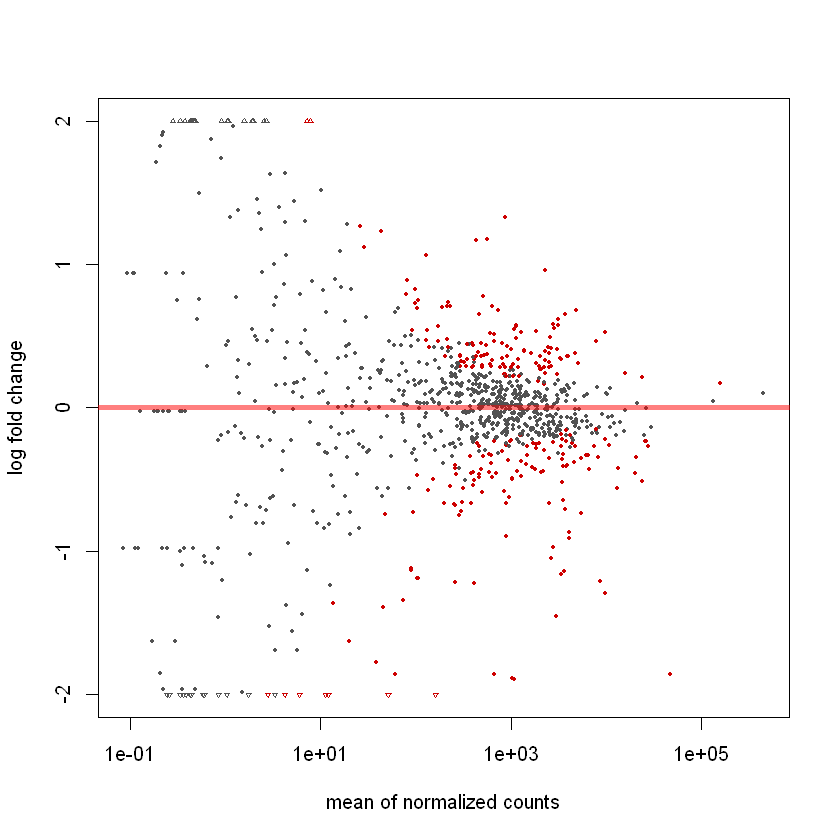

In [186]:
plotMA(res, ylim=c(-2,2))

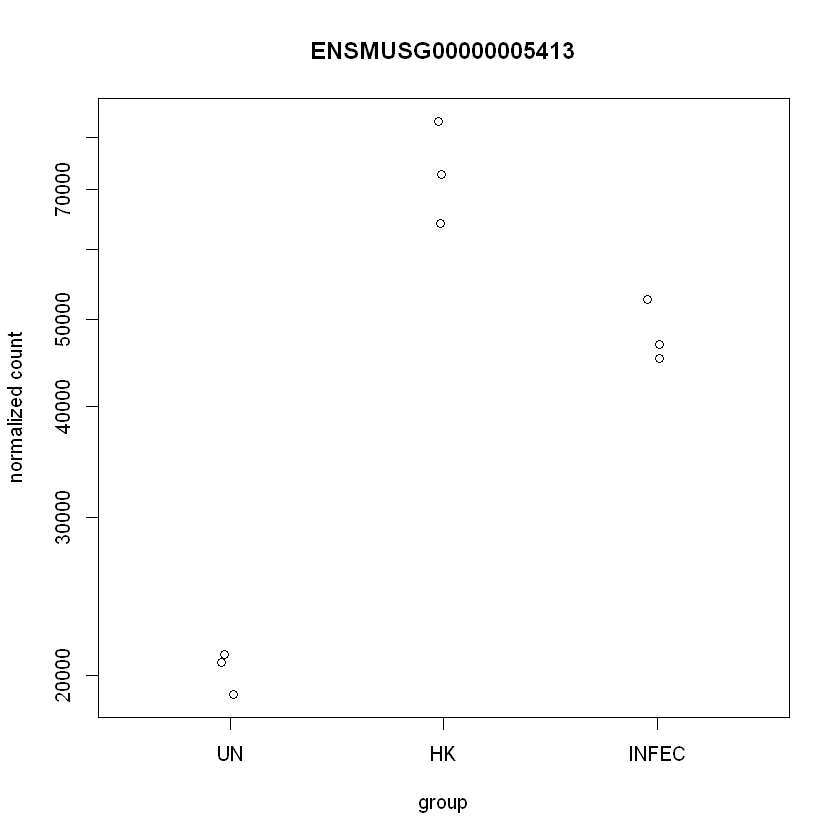

In [187]:
plotCounts(dds, gene=which.min(res$padj), intgroup="condition")

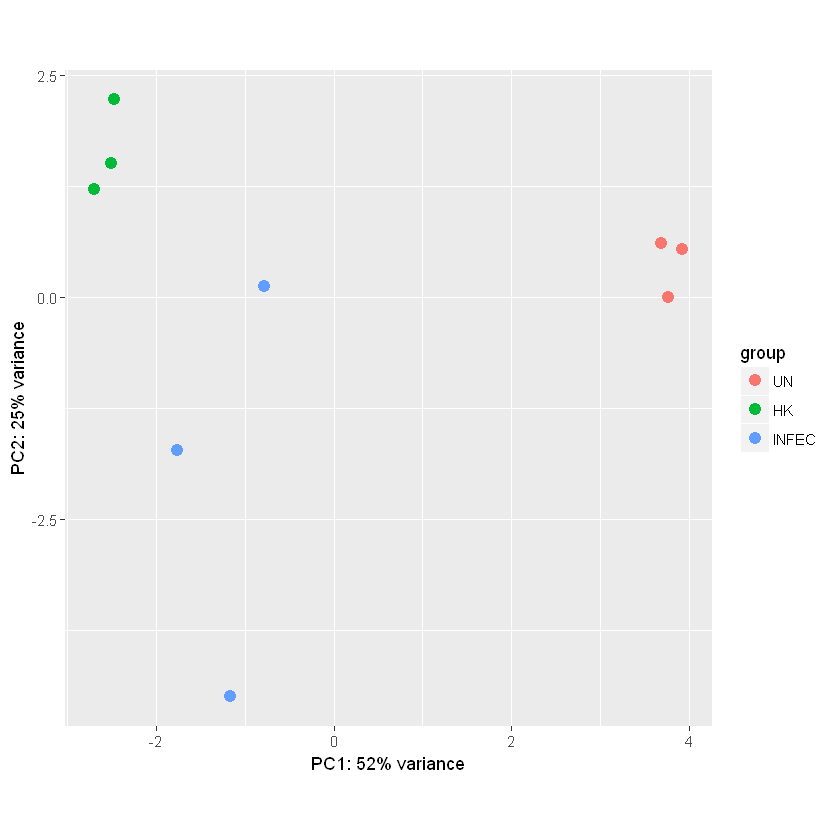

In [193]:
# vsd <- vst(dds, blind=FALSE)
rld <- rlog(dds, blind=FALSE)
plotPCA(rld, intgroup=c("condition"))

In [199]:
sampleDists <- dist(t(assay(rld)))

In [203]:
library("RColorBrewer")
library("pheatmap")

In [207]:
sampleDists

          HK1cnt   HK2cnt   HK3cnt  INF2cnt  INF3cnt  INF4cnt   M01cnt   M02cnt
HK2cnt  3.397618                                                               
HK3cnt  4.615692 3.314634                                                      
INF2cnt 4.625126 5.284141 5.571452                                             
INF3cnt 3.988705 4.377213 5.126246 3.610438                                    
INF4cnt 7.057336 7.383264 6.685015 4.870071 6.013126                           
M01cnt  7.099300 6.865949 7.188868 6.720606 5.573369 7.596965                  
M02cnt  7.331111 7.178529 7.241183 6.941433 5.915105 7.234608 2.953553         
M03cnt  7.099607 7.209091 7.720351 6.791892 5.586744 7.817899 2.765865 3.235547

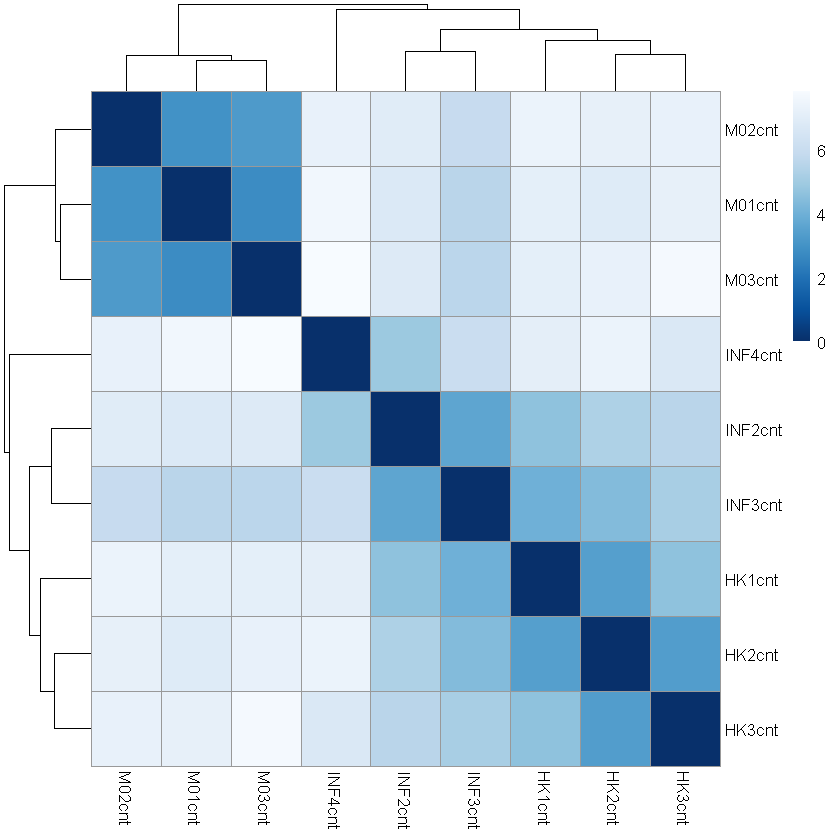

In [208]:
sampleDistMatrix <- as.matrix(sampleDists)
colors <- colorRampPalette( rev(brewer.pal(9, "Blues")) )(255)
pheatmap(sampleDistMatrix,
         clustering_distance_rows=sampleDists,
         clustering_distance_cols=sampleDists,
         col=colors)

In [195]:
resOrdered <- res[order(res$padj),]

In [196]:
write.csv(as.data.frame(res), file="UN_HK_results.csv")
write.csv(as.data.frame(resOrdered), file="UN_HK_results_ordered.csv")